# Sequential binary classification

## Introduction

In this notebook, we will perform sequential binary classification analysis using LLMs. Binary classification refers to the task of categorizing data entries into one of two predefined categories. Here, we explore a specific case where binary classifications are conducted sequentially, with the final classification outcome depending on the results of prior classifications.

### Dataset Description

The dataset used in this notebook is an anonymized subset from the study available at [X]. In the original experiment, children were tasked with reading a reference text and engaging in four sequential interactions with an interactive app. The goal of these steps was to help the children formulate a divergent question. A question is considered divergent if its answer is not explicitly stated in the reference text.

The four steps, include:
1. **Identify**: The child identifies a knowledge gap related to the reference text.
2. **Guess**: The child makes a guess about what the answer to the knowledge gap could be.
3. **Seek**: The child formulates a question to seek the answer.
4. **Assess**: The child evaluates whether the app provides an answer to their question.

This process is called a **cycle**. An annotator evaluates the validity of a cycle by answering a series of binary Yes/No questions (binary classifications). A cycle is deemed valid if all binary questions can be answered by "Yes"; otherwise, it is considered invalid. For more details, see the codebook provided in the prompt cell.

### Dataset Structure

The dataset includes the following key components:
- **Reference Text**: A column containing the text that children were asked to read beforehand.
- **Identify**: A column containing the entries posed by the children during the Identify step.
- **Guess**: A column containing the entries posed by the children during the Guess step.
- **Seek**: A column containing the entries posed by the children during the Seek step.
- **Assess**: A column containing the entries posed by the children during the Assess step.

To classify a cycle, both the reference text and the entries from all four steps are required.

Additionally, the dataset includes ratings from two human annotators. These ratings enable us to compute inter-annotator agreement metrics, such as Cohen's kappa, to assess the reliability of the annotations once the analysis is complete.

## Import the libraries

In [1]:
import os
import pandas as pd
from qualitative_analysis import (
    load_data,
    clean_and_normalize,
    sanitize_dataframe,
    get_llm_client,
    compute_all_kappas,
    plot_confusion_matrices,
    extract_global_validity,
    process_verbatims_for_binary_criteria # Additional import if you want to save the results of the classification as a csv
)
import qualitative_analysis.config as config

## Load the data

In [2]:
# Define data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Define the path to your dataset
data_file_path = os.path.join(data_dir, 'sequential_binary_sample.csv')

# Load the data
data = load_data(data_file_path, file_type='csv', delimiter=';')

# Preview the data
data.head()

,ID,reference,Identify,Guess,Seek,Assess,corr_cycle1
0,BC23,"À des dizaines de kilomètres sous nos pieds, l...","Le manteau,le centre de la Terre",Je pense que le manteau et le centre de la Ter...,Le manteau et le centre de la Terre ne font il...,Je n'ai pas pu trouver la réponse à ma question.,1
1,BC14,"À des dizaines de kilomètres sous nos pieds, l...",Température du magma,La température du magma s'élève à plus de 100...,à combien de °cle magma est?,La température du magma atteint les 1000 °C,1
2,BC5,"À des dizaines de kilomètres sous nos pieds, l...",Pourqoi on l'appelle le manteau.,le magma et une pierre.,quel et la temperature magma,1 000c,0
3,BC22,"À des dizaines de kilomètres sous nos pieds, l...",La température du magma,La température du magma dépasse les 500 °C,Quel est la température du magma ?,La température du magma atteint les 1000 °C,1
4,BC20,"À des dizaines de kilomètres sous nos pieds, l...",Combien de couches y-t-il ?,Il existe d'autre couches dans la terre à par...,Quelles sont les autres couches et combien son...,La terre contient 7 couches dont le noyau.,1


## Data Preprocessing

In [ ]:
# 1a) Define a mapping from old column names to new names
# rename_map = {
#     "ref": "reference",
#     "txt1.ctrl1": "Identify",
#     "txt1.det": "Guess",
#     "txt1.exp": "Seek",
#     "txt1.ctrl2": "Assess"
# }

# # 1b) Rename the columns in the DataFrame
# data = data.rename(columns=rename_map)

# 2) Now define the new column names for cleaning
text_columns = ["reference", "Identify", "Guess", "Seek", "Assess"]

# 3) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 4) Sanitize the DataFrame
data = sanitize_dataframe(data)


c:\Users\ocler\Documents\Académique\Inria\qualitative_analysis_project\qualitative_analysis\data_processing.py:141: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


## Combine Texts and Questions

In [ ]:
# Combine texts and entries

data['verbatim'] = data.apply(
    lambda row: (
        f"Id: {row['ID']}\n\n"
        f"Text: {row['reference']}\n\n"
        f"Identify: {row['Identify']}\n\n"
        f"Guess: {row['Guess']}\n\n"
        f"Seek: {row['Seek']}\n\n"
        f"Assess: {row['Assess']}\n\n"
    ),
    axis=1
)

# Extract the list of verbatims
verbatims = data['verbatim'].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 45
Verbatim example:
Id: BC23

Text: À des dizaines de kilomètres sous nos pieds, la terre contient une couche quon appelle le manteau. Il fait tellement chaud sur cette couche que les roches deviennent liquides : cest ce qu'on appelle le magma. Le magma est responsable de l'explosion des volcans: c'est ce que les scientifiques appellent aussi une éruption d'un volcan. On dit quun volcan est endormi sil ny a eu aucune éruption dans les 10 000 dernières années. Au delà de 10 000 ans, on peut dire que le volcan est éteint.

Identify: Le manteau,le centre de la Terre

Guess: Je pense que le manteau et le centre de la Terre sont les màames choses

Seek: Le manteau et le centre de la Terre ne font ils qu'un?

Assess: Je n'ai pas pu trouver la réponse à  ma question.




## Choose the LLM

In [5]:
# Choose the provider and model
provider = 'azure'
model_name = 'gpt-4o-mini'

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

## Prompt Construction and Classification

In [6]:
# Define instructions for multiclass classification
# Classification settings
reasoning = False  # If True, perform two-step reasoning. If False, single-step classification.
verbose = True # If True, show the prompt

# Select subset of verbatims for testing
subset = 10
verbatims_subset = verbatims[:subset]

codebook = {
    "Identify Step": "Does the Identify step indicate a topic of interest?",
    "Guess Step": "Does the Guess step suggest a possible explanation?",
    "Seek Step": "Is the Seek step formulated as a question?",
    "Assess Step": "Does it identify a possible answer or state that no answer was found ('no' is ok)?",
    "Consistency": "Are the Identify, Guess, and Seek steps related to the same question?",
    "Reference Link": "Are the Identify, Guess, and Seek steps related to the topic of the reference text?",
    "Seek Question Originality": "Is the answer to the Seek question not found (even vaguely) in the reference text?",
}

# """
# Exemple:

# Identify: "I don’t understand how rain forms."
# Guess: "Maybe rain condenses in the sky, forming droplets."
# Seek: "How does rain form?"
# Assess: "No"
# Reference: "Rain forms when water evaporates into the atmosphere, condenses into droplets, and falls due to gravity."

# Identify Step: Does the Identify step indicate a topic of interest?
# Yes: The topic is the formation of rain. 1
# - Guess Step: Does the Guess step suggest a possible explanation?
# Yes: It proposes condensation as the mechanism for rain formation. 1
# - Seek Step: Is the Seek step formulated as a question?
# Yes: It is explicitly phrased as a question with an interrogative structure. 1
# - Assess Step: Does it identify a possible answer or state that no answer where found ("no" is ok) ?
# Yes: It is stated that the answer to the question was not found, which is a valid answer in the Assess step. 1
# - Consistency: Are the Identify, Guess, and Seek steps related to the same question?
# Yes: They all pertain to the process of rain formation. 1
# - Reference Link: Are the Identify, Guess, and Seek steps related to the topic of the reference text?
# Yes: The text discusses rain and explains its formation. 1
# - Seek Question Originality: Is the answer to the Seek question not found (even vaguely) in the reference text?
# No: The answer is explicitly provided in the reference text. 0
# - If the Assess step state an answer, does it answer to the question in the Seek step ?
# Yes: "No" is a possible response, indicating that a response to the answer was not found. 1
# - Cycle Resolution: Does the answer to the Seek question resolve the topic identified in the Identify step?
# Yes: The Seek question directly addresses the knowledge gap in the Identify step. 1
# """

# Define column descriptions
column_descriptions = (
    "ID: Unique identifiant of the participant\n"
    "Text: The reference text that participants must read beforehand. Their responses for the different steps must be semantically related to this text (same topic), but the answer to the question they are asking should not be found in the text.\n"
    "Identify: Response for the IDENTIFY step\n"
    "Guess: Response for the GUESS step\n"
    "Seek: Response for the SEEK step\n"
    "Assess: Response for the ASSESS step"
)

# Define queries for multiclass classification and reasoning
binary_query = "Reply with '1' if the entry meets the criterion or '0' otherwise."
reasoning_query = "First, generate a one-sentence reasoning about the classification."

# To be sure to have an integer only when doing 1 call request
command = (
    "Minor errors in spelling, grammar or wording should not be penalised as long as the intention of the entry is clear and meets the inclusion criteria. Focus on the content and purpose of the entry rather than on linguistic perfection."
    if not reasoning
    else "Minor errors in spelling, grammar or wording should not be penalised as long as the intention of the entry is clear and meets the inclusion criteria. Focus on the content and purpose of the entry rather than on linguistic perfection."
)

prompt_template = f"""
You are an evaluator provided with data entries in the following format:
{column_descriptions}

You are tasked with evaluating the following entry.

Entry:
{{verbatim_text}}

You should evaluate it like this:
{{codebook}}
{command}
"""

results_binary, verbatim_costs_binary = process_verbatims_for_binary_criteria(
    verbatims_subset=verbatims_subset,
    codebooks=codebook,
    llm_client=llm_client,
    model_name=model_name,
    prompt_template=prompt_template,
    reasoning_query=reasoning_query,
    binary_query=binary_query,
    reasoning=reasoning,
    verbose=verbose
)

for result in results_binary:
    print(result)

results_df = pd.DataFrame(results_binary)


=== Processing Verbatim 1/10 ===

--- Evaluating Theme: Identify Step ---
Prompt:

You are an evaluator provided with data entries in the following format:
ID: Unique identifiant of the participant
Text: The reference text that participants must read beforehand. Their responses for the different steps must be semantically related to this text (same topic), but the answer to the question they are asking should not be found in the text.
Identify: Response for the IDENTIFY step
Guess: Response for the GUESS step
Seek: Response for the SEEK step
Assess: Response for the ASSESS step

You are tasked with evaluating the following entry.

Entry:
Id: BC23

Text: À des dizaines de kilomètres sous nos pieds, la terre contient une couche quon appelle le manteau. Il fait tellement chaud sur cette couche que les roches deviennent liquides : cest ce qu'on appelle le magma. Le magma est responsable de l'explosion des volcans: c'est ce que les scientifiques appellent aussi une éruption d'un volca

## Extraction of Overall Validity (Optional)

After performing sequential binary classifications, we obtained a series of binary outcomes (`0` for invalid and `1` for valid) for each step in the cycle. Depending on the analysis goal, it may be useful to perform an additional step to assess the overall validity of each cycle.

In the KidsReflect dataset, a cycle is considered **valid** only if **all** individual binary classifications are valid (`1`). If any of the classifications are invalid (`0`), the entire cycle is deemed **invalid**.

In this step, we extract the overall validity of each cycle based on the results of the sequential binary classifications.


In [7]:
# Extract global validity
global_validity_df = extract_global_validity(
    results_df, 
    id_pattern=r'Id:\s*(\w+)',      # ID pattern
    label_column='Label',          # label column
    verbatim_column='Verbatim',        # verbatim column
    global_validity_column='Global_Validity',   # output column for validity
    verbatim_output_column='Verbatim'  # output column for verbatim
)

## Saving the Results

This step provides an option to save the classification results to a file for future reference or further analysis.

In [8]:
# Possibility to save the results

# # Define the save path
# outputs_dir = os.path.join(data_dir, 'outputs')
# os.makedirs(outputs_dir, exist_ok=True)
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# # Save results
# save_results_to_csv(
#     coding=results_df.to_dict('records'),
#     save_path=save_path,
#     fieldnames=['Verbatim', 'Label'],
#     verbatims=None  # Verbatims are included in the results
# )

## Evaluating Model Performance Against Human Annotations

### Computing Cohen's Kappa

In this step, we compare the model's classifications with human annotations using Cohen's Kappa.

1. **Unweighted Kappa**:  
   All disagreements are treated equally, regardless of the "distance" between the categories. For example, a mismatch between `0` and `1` is penalized the same as a mismatch between `0` and `2`.

2. **Linear Weights**:  
   With `weights='linear'`, disagreements are penalized proportionally to their distance. For instance:
   - A mismatch between `0` and `1` incurs a smaller penalty than a mismatch between `0` and `2`.
   - This approach is suitable when the categories have a natural ordering (e.g., `0 < 1 < 2`) but the differences are not exponential.

3. **Quadratic Weights**:  
   With `weights='quadratic'`, disagreements are penalized more heavily as the distance increases. This approach emphasizes larger disagreements even more than linear weights.



In [9]:
# Assuming you have human annotations in the data
model_coding = global_validity_df['Global_Validity'].tolist()
model_coding = [int(x) for x in model_coding]

human_annotations = {
    'human1': [int(x) for x in data['corr_cycle1'].tolist()],
}

# Shorten data for demonstration if needed
model_coding_short = model_coding[:subset]
human_annotations_short = {rater: ann[:subset] for rater, ann in human_annotations.items()}

# Compute Cohen's Kappa for all pairings and print results
kappa_results = compute_all_kappas(
    model_coding_short,
    human_annotations_short,
    labels=[0, 1, 2],
    weights='linear',
    verbose=True
)

Model vs human1: 0.00


### Visualizing Agreement

In this step, we plot confusion matrices to visualize the agreement between the model's classifications and human annotations, or between two human annotations.

**Inputs**:
- `model_coding_short`: The model's predictions for the subset of data.
- `human_annotations_short`: The annotations from human raters for the same subset.

**Labels**:
- `[0, 1, 2]`: The three classification categories representing:
   - `0`: The answer is explicitly in the text.
   - `1`: The answer can be inferred from the text.
   - `2`: The answer is not in the text at all.


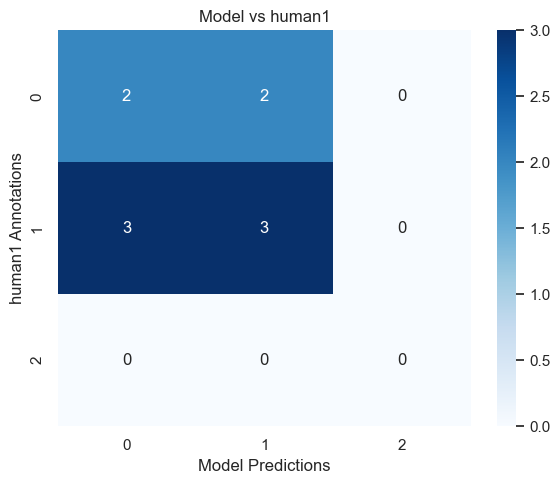

In [10]:
# Plot confusion matrices for all comparisons
plot_confusion_matrices(model_coding_short, human_annotations_short, labels=[0, 1, 2])